<h3 style="text-align:center">Image and text classification using CNN</h3>

Image classification

In [ ]:
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()

Inferencing

In [9]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    labels = eval(f.read())

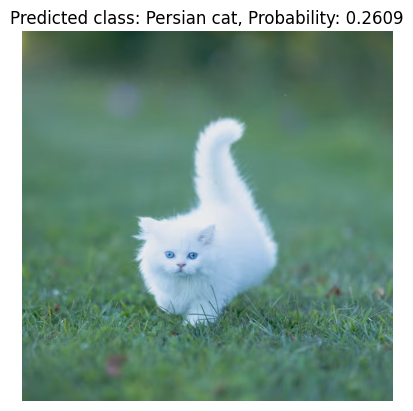

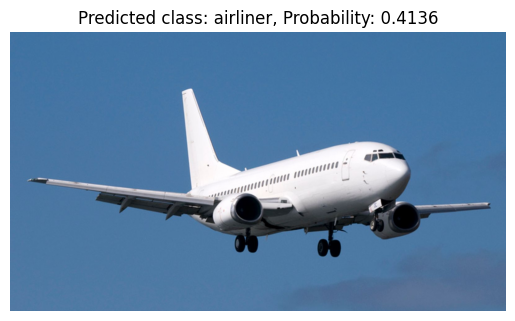

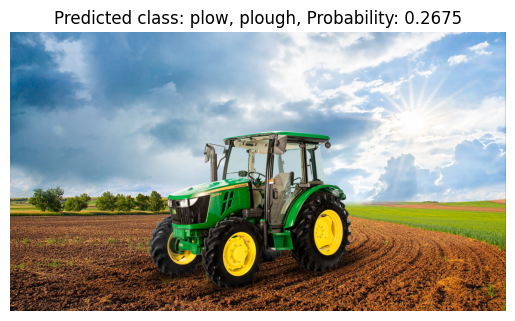

In [ ]:
preprocessor = ResNet50_Weights.IMAGENET1K_V2.transforms()
test_images = ["cat.png", "plane.png", "tractor.png"]

for img_path in test_images:
    test_image = Image.open(img_path).convert("RGB")
    input_tensor = preprocessor(test_image)
    input_image = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_image)

    predicted_probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_probabilities, predicted_classes = torch.topk(predicted_probabilities, 5)

    label = labels[predicted_classes[0].item()]
    probability = predicted_probabilities[0].item()

    plt.imshow(test_image)
    plt.axis('off')
    plt.title(f"Predicted class: {label}, Probability: {probability:.4f}")
    plt.show()

Text classification

In [17]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd

In [22]:
dataset = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

In [ ]:
dataset

Creating a CNN for text classification

In [34]:
x = torch.randint(0, 1000, (100, 50))  # Example input data
x = torch.nn.Embedding(1000, 64)(x)  # Embedding layer
print(x.shape)  # Should be (100, 50, 64)
x = x.permute(0, 2, 1)  # Change shape to
print(x.shape)  # Should be (100, 64, 50)
x = nn.Conv1d(64, 32, kernel_size=3)(x)
print(x.shape)  # Should be (100, 32, 48)
x = nn.ReLU()(x)
x = nn.MaxPool1d(kernel_size=2)(x)
print(x.shape)  # Should be (100, 32, 24)

x = x.view(x.size(0), -1)  # Flatten
print(x.shape)  # Should be (100, 32*24)


torch.Size([100, 50, 64])
torch.Size([100, 64, 50])
torch.Size([100, 32, 48])
torch.Size([100, 32, 24])
torch.Size([100, 768])


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv1 = nn.Conv1d(embed_dim, 128, 3)
        self.conv2 = nn.Conv1d(128, 64, 3)
        self.conv3 = nn.Conv1d(64, 32, 3)

        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * 24, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.sigmoid(x)

        return x
